# Classification with CNNs

## Imports

In [ ]:
## Verifying that the system is correctly configured

moduleNames = [
    "numpy",
    "scipy",
    "pandas",
    "seaborn",
    "astropy",
    "sklearn",
    "tensorflow",
    "matplotlib",
    "tensorflow_datasets",
]
modules = map(__import__, moduleNames)

# for m in modules:
#     print(m.__name__, m.__version__)

In [ ]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from astropy.io import ascii
from astropy.table import Table
import urllib.request
from astropy.io import fits
import tarfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Dropout
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import model_from_json
import tensorflow_datasets as tfds
from tensorflow.keras.applications import *

from sklearn import svm, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize

# from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.rcParams.update({"font.size": 18})

## Paths

In [ ]:
base_dir = os.getcwd() ##USER INPUT NEEDED##
data_dir =  base_dir + '/GZ_DECaLS/' ##USER INPUT NEEDED## # folder where to store the training images
pred_dir =  base_dir + '/pred_images/' ##USER INPUT NEEDED## # folder where to store the images for prediction

## Filtering out bad images



In [ ]:
removed = []
for file_name in os.listdir(data_dir):
    if file_name.endswith('.fits'):
        file_path = os.path.join(data_dir, file_name)
        with fits.open(file_path) as hdul:
            header = hdul[0].header
            data = hdul[1].data
            if np.any(np.isnan(data))==True:
                ! rm file_name
                removed.append(file_name[:-5])
            elif np.any(np.isinf(data))==True:
                ! rm file_name
                removed.append(file_name[:-5])

In [ ]:
#Check to see how many bad images were removed
print(len(removed))

0


## Visualizing the data


In [ ]:
#Labels of different galaxy morphologies
csv_file = 'gz_decals_volunteers_1_and_2.csv'
table = Table.read(csv_file, format='csv')

In [ ]:
#Checking the table columns
# for col in table.columns:
#     print(col)

In [ ]:
#Looking at average redshift
print(table['redshift'].mean())

0.08750017957776779


In [ ]:
#Looking at the training images
img_files = [f for f in os.listdir(data_dir) if f.endswith('.fits')]
print(img_files)
barred = []
unbarred = []
nothing = []

#Sorting each training image into respective morphology (barred or non-barred)

for img_file in img_files:
    name = img_file[:-5]
    row = table[table['iauname'] == name]
    bar_fraction = np.any(row['bar_yes_fraction'])
    nobar_fraction = np.any(row['bar_no_fraction'])
    edge_on_no = np.any(row['disk-edge-on_no_fraction'])
    smooth = np.any(row['smooth-or-featured_featured-or-disk_fraction'])
    if bar_fraction >= 0.8:
        barred.append(img_file)
    elif nobar_fraction >= 0.8:
        unbarred.append(img_file) 
    else:
        nothing.append(img_file)


['J222324.75+010819.3.fits', 'J234241.31+020404.7.fits', 'J233633.58-004554.9.fits', 'J224158.94+005148.0.fits', 'J231602.23-000742.8.fits', 'J230411.70+010745.4.fits', 'J225052.73+003152.5.fits', 'J232054.96+002809.0.fits', 'J230524.11+004715.2.fits', 'J223439.57+010144.3.fits', 'J223414.43+005600.5.fits', 'J221026.34-004057.4.fits', 'J235606.40+000957.6.fits', 'J223201.04-004308.9.fits', 'J231610.26-005914.8.fits', 'J224029.49-000344.8.fits', 'J224554.23+003014.3.fits', 'J235917.76+001859.7.fits', 'J223940.67-003035.6.fits', 'J231541.65+003952.8.fits', 'J231608.93-004106.6.fits', 'J231525.92+011044.1.fits', 'J223611.10+012429.9.fits', 'J232452.14-001823.4.fits', 'J220926.01-001038.7.fits', 'J224906.86-002437.8.fits', 'J221353.04+002413.7.fits', 'J220728.11+002114.3.fits', 'J222955.88-002958.2.fits', 'J235526.81-001414.4.fits', 'J221030.70+003101.8.fits', 'J231501.70+000424.0.fits', 'J220347.62-004602.5.fits', 'J220043.44+003641.3.fits', 'J223515.03+003345.0.fits', 'J225433.09+013838.

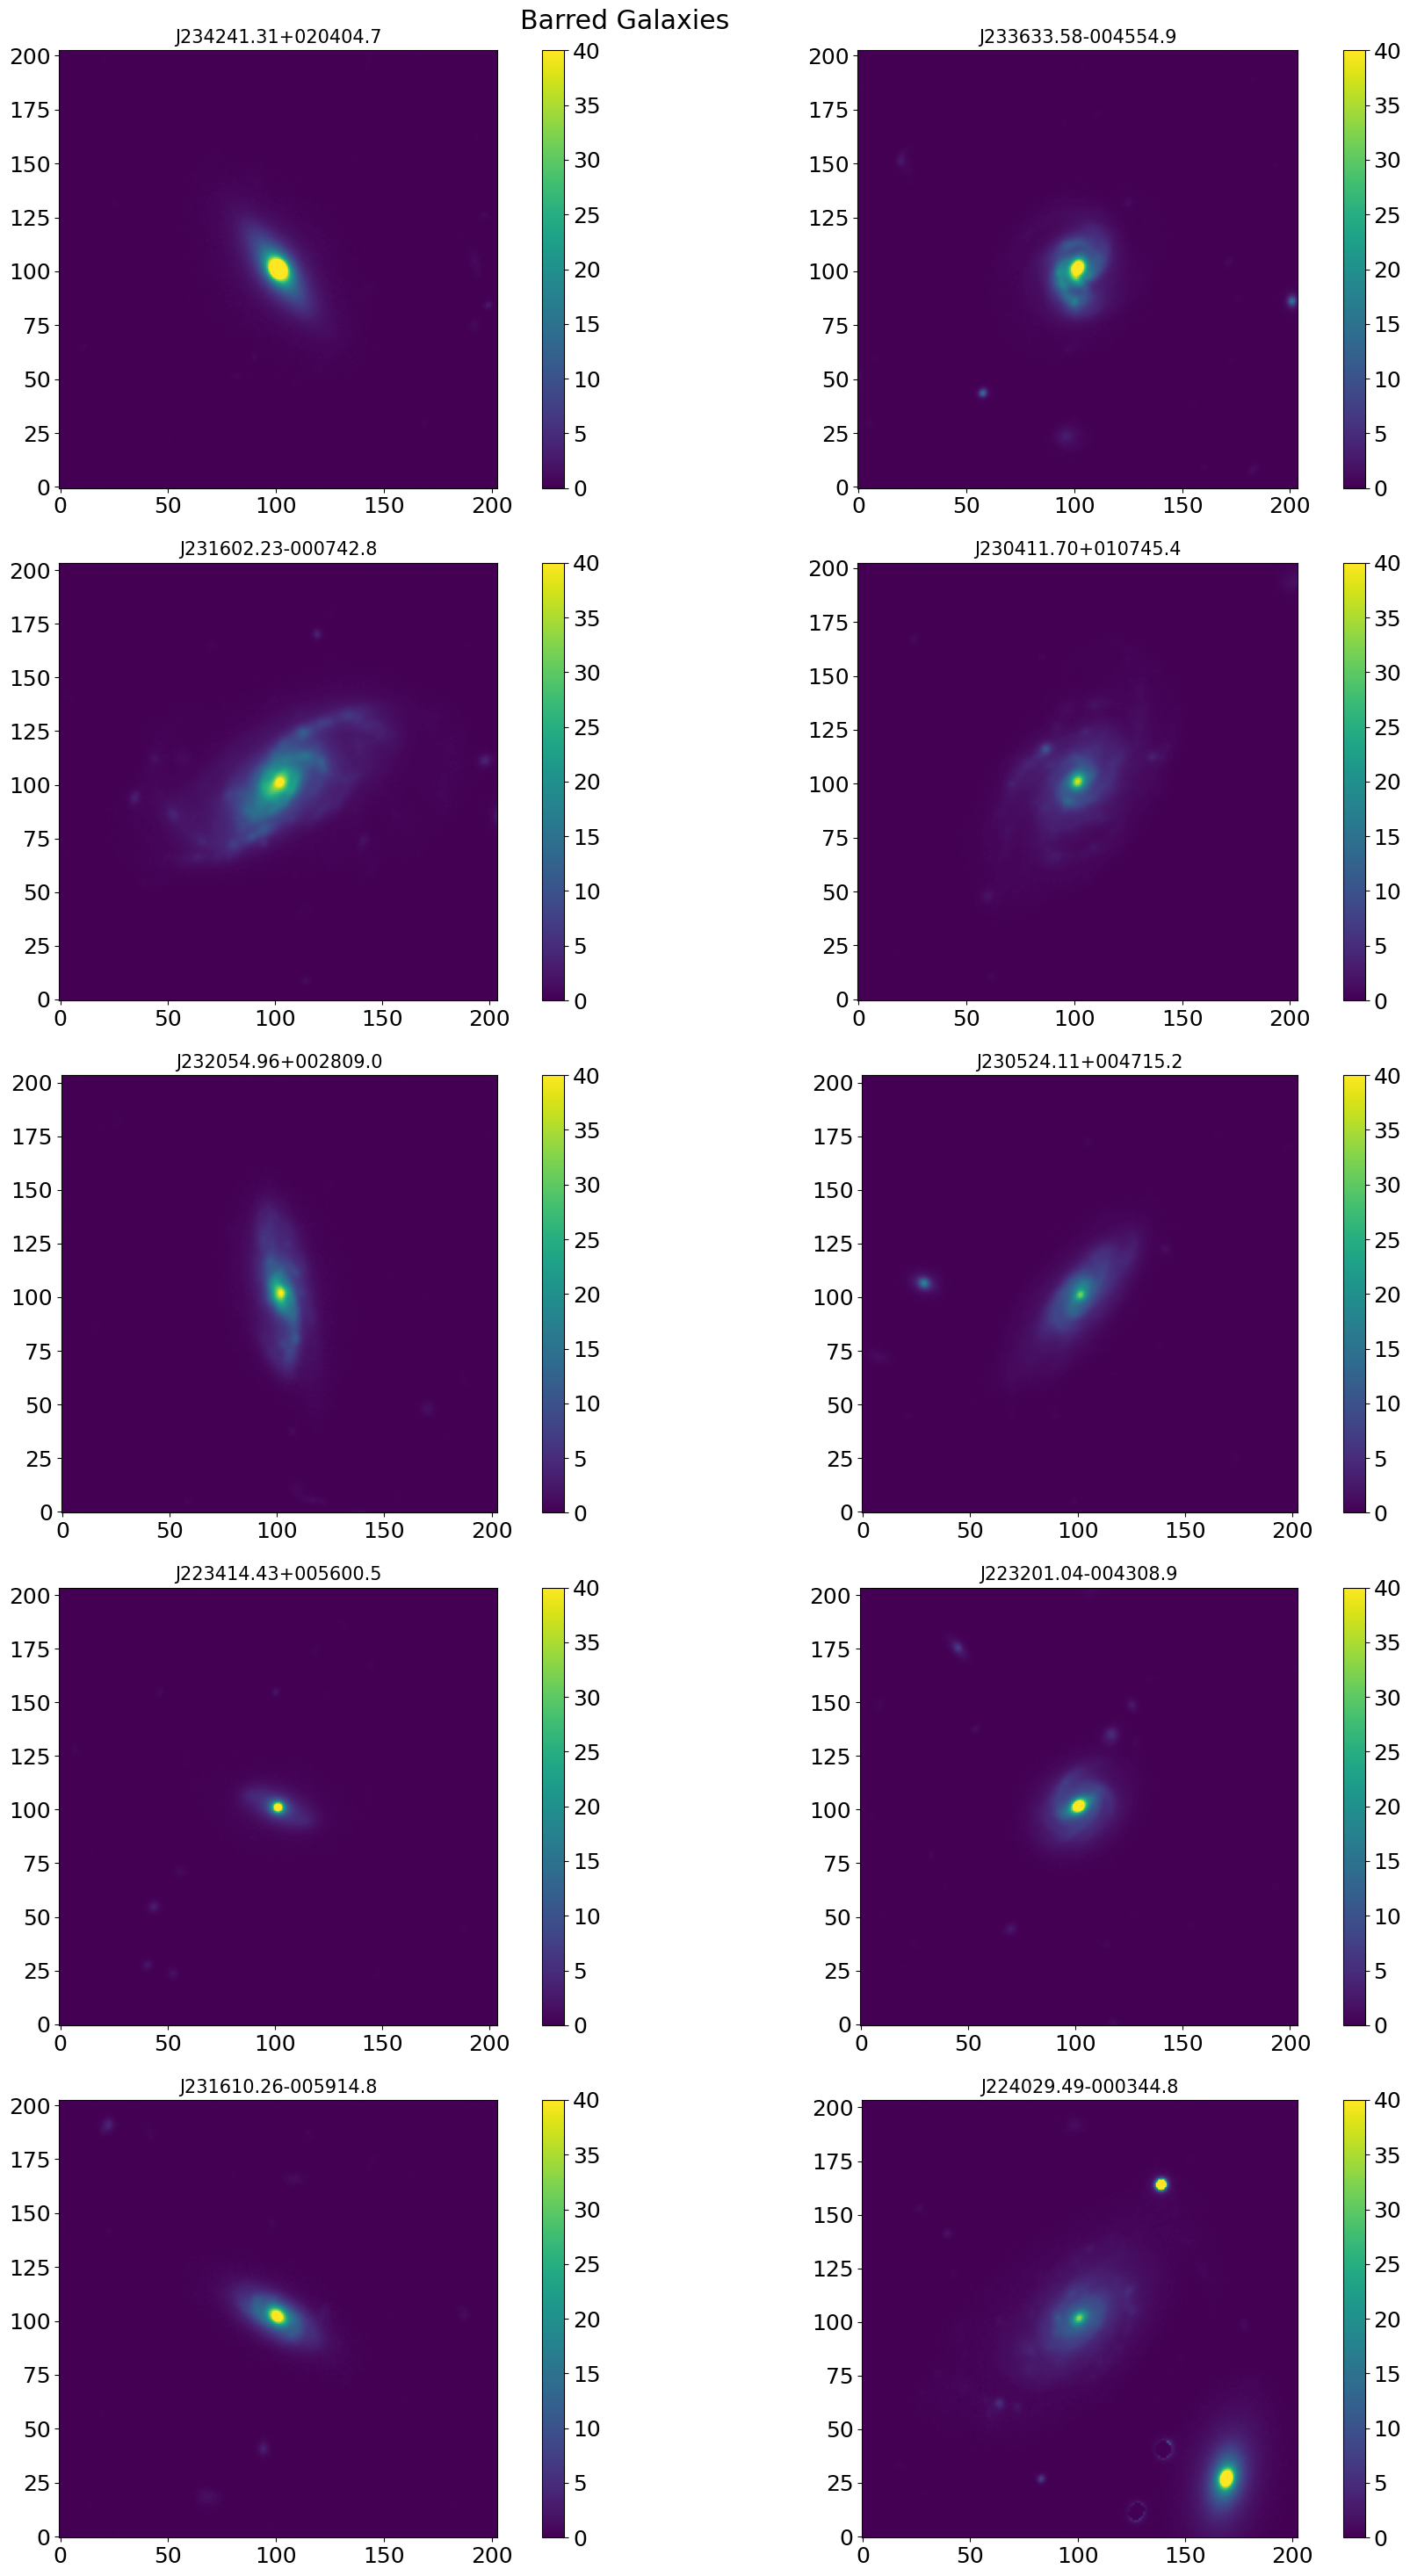

In [ ]:
#Plotting the first 10 barred galaxies of data 
fig, ax = plt.subplots(5,2, figsize=(20,30))
ax = ax.flatten()
count=0
for bar in barred:
    file_path = os.path.join(data_dir, bar)
    with fits.open(file_path) as hdul:
        header = hdul[0].header
        data = hdul[1].data

        cm = ax[count].imshow(data, cmap='viridis', origin='lower', vmin=0, vmax=40)
        ax[count].set_title(f'{bar[:-5]}', fontsize=15)
        fig.colorbar(cm, ax=ax[count])
        
        count += 1
        if count >= 10:
            break
        hdul.close()

fig.suptitle("Barred Galaxies")
plt.tight_layout()
plt.show()

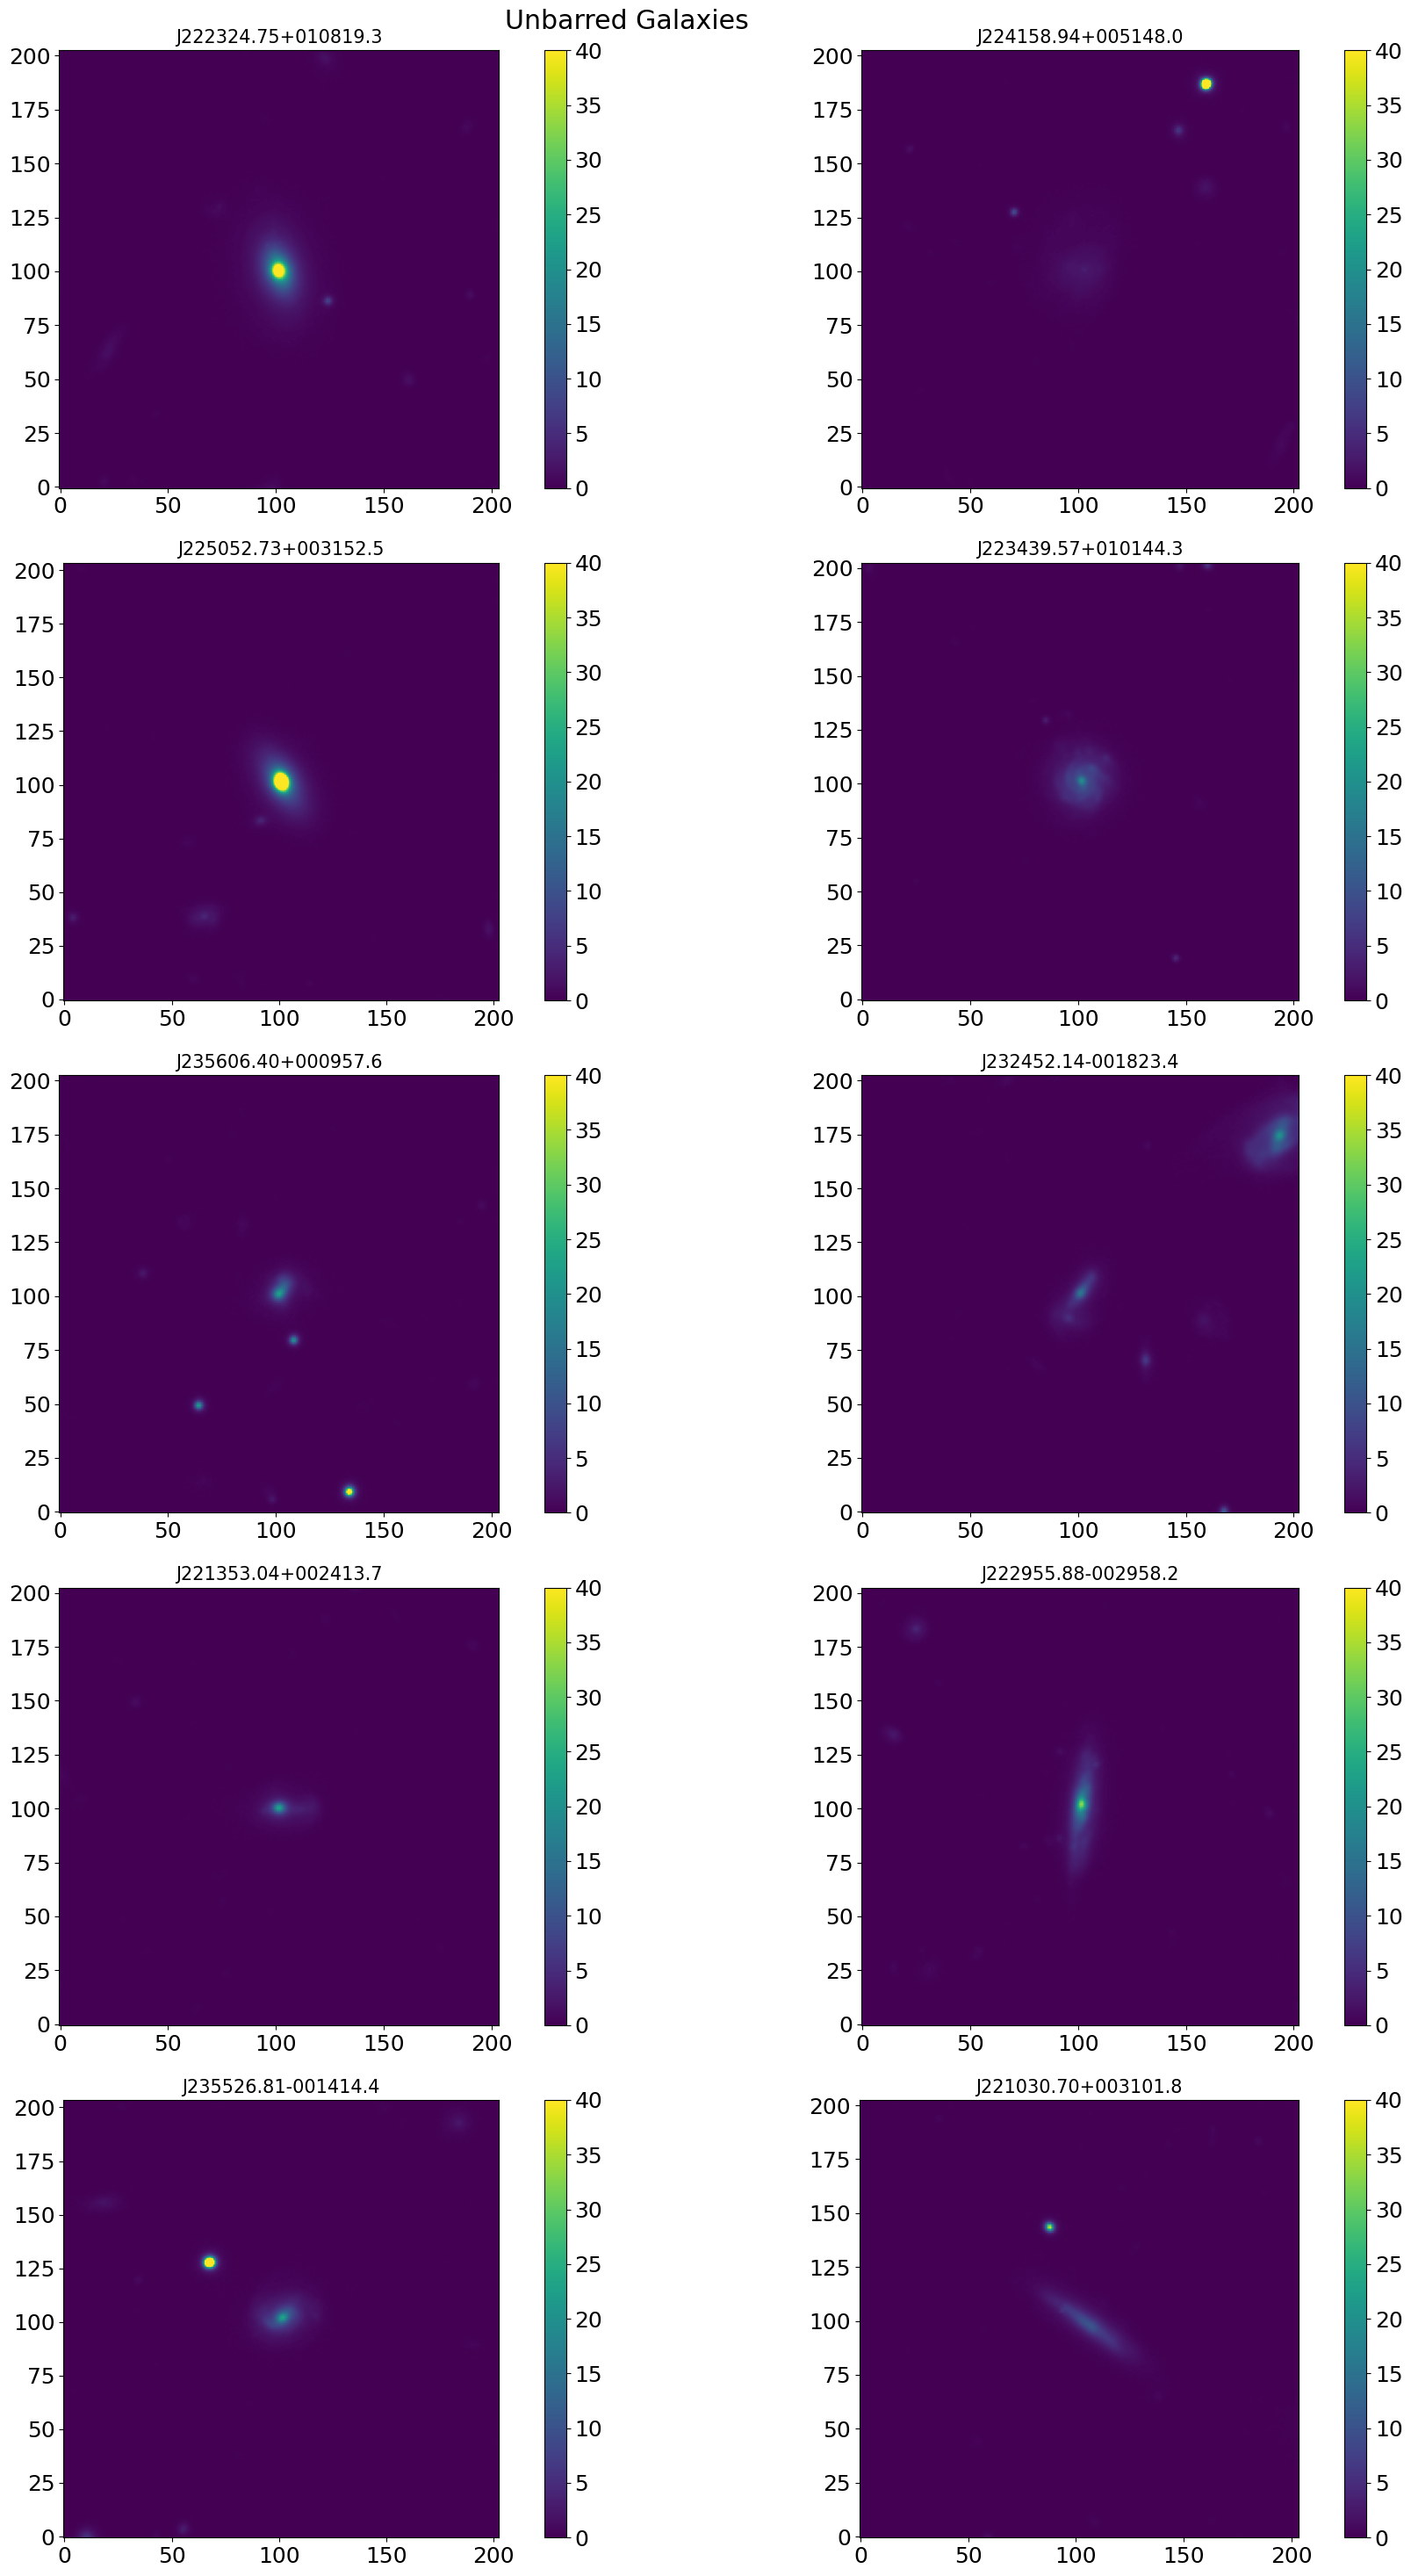

In [ ]:
#Plotting the first 10 unbarred galaxies of data
fig, ax = plt.subplots(5,2, figsize=(20,30))
ax = ax.flatten()
count=0
for unbar in unbarred:
    file_path = os.path.join(data_dir, unbar)
    with fits.open(file_path) as hdul:
        header = hdul[0].header
        data = hdul[1].data

        cm = ax[count].imshow(data, cmap='viridis', origin='lower', vmin=0, vmax=40)
        ax[count].set_title(f'{unbar[:-5]}', fontsize=15)
        fig.colorbar(cm, ax=ax[count])
        
        count += 1
        if count >= 10:
            break
        hdul.close()

fig.suptitle("Unbarred Galaxies")
plt.tight_layout()
plt.show()

## Generating Datasets for tensorflow
 

In [ ]:
# os.chdir(base_dir)
# ! tfds new my_dataset  # Create `my_dataset/my_dataset.py` template files
# # [...] Manually modify `my_dataset/my_dataset_dataset_builder.py` to implement your dataset.

/Software/users/modules/9/software/anaconda3/2023.03/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset generated at /net/virgo01/data/users/barrow/Astronomical_Data_Science/my_dataset
You can start searching `TODO(my_dataset)` to complete the implementation.
Please check https://www.tensorflow.org/datasets/add_dataset for additional details.


In [ ]:
#PATHS#
path = '...' ##USER INPUT##
dir_train = path + 'train/' ##USER INPUT##
dir_test = path + 'test/' ##USER INPUT##
dir_val = path + 'val/' ##USER INPUT##

In [ ]:
#Checking how much initial data we have
print(len(barred))
print(len(unbarred))
print(len(nothing))

4155
3167
304


In [ ]:
#Scaling the data, and saving it as an image again
def scale_and_save(input_path):
    scaler = StandardScaler()

    os.makedirs(input_path + 'barred/', exist_ok=True) 
    os.makedirs(input_path + 'unbarred/', exist_ok=True)

    for bar in barred:
        with fits.open(input_path + bar) as im:
            data = im[1].data
            scaler.fit(data.reshape(-1, 1))
            scaled_data = scaler.transform(data.reshape(-1, 1)).reshape(data.shape)
            im[1].data = scaled_data
            im.writeto(input_path + 'barred/' + bar, overwrite=True) 

    for unbar in unbarred:
        with fits.open(input_path + unbar) as im:
            data = im[1].data
            scaler.fit(data.reshape(-1, 1))  
            scaled_data = scaler.transform(data.reshape(-1, 1)).reshape(data.shape)
            im[1].data = scaled_data
            im.writeto(input_path + 'unbarred/' + unbar, overwrite=True)

scale_and_save(path)



NameError: name 'path' is not defined

In [ ]:
#Getting the barred and unbarred images
bar_files = [f for f in os.listdir(path + 'barred/') if f.endswith('.fits')]
unbar_files = [f for f in os.listdir(path + 'unbarred/') if f.endswith('.fits')]

#Splitting into train, test, validation - 20%
trainval_bar, test_bar = train_test_split(bar_files, test_size=0.2)
train_bar, val_bar = train_test_split(trainval_bar, test_size=0.2)

trainval_unbar, test_unbar = train_test_split(unbar_files, test_size=0.2)
train_unbar, val_unbar = train_test_split(trainval_unbar, test_size=0.2)

In [ ]:
# Placing these new datasets into the right folder
def saving(file_name, input_path, output_dir):
    with fits.open(input_path + file_name) as im:
        im.writeto(output_dir + file_name, overwrite=True)

for test_, train_, val_ in zip(test_bar, train_bar, val_bar):
    saving(test_, path + 'barred/', dir_test)
    saving(train_, path + 'barred/', dir_train)
    saving(val_, path + 'barred/', dir_val)

for test_un, train_un, val_un in zip(test_unbar, train_unbar, val_unbar):
    saving(test_un, path + 'unbarred/', dir_test)
    saving(train_un, path + 'unbarred/', dir_train)
    saving(val_un, path + 'unbarred/', dir_val)

In [ ]:
os.chdir(base_dir + '/my_dataset/')

! tfds build  # Download and prepare the dataset to `~/tensorflow_datasets/`

In [ ]:
tfds_name = 'my_dataset:1.0.0' ##USER INPUT NEEDED##
datasets_path = '...'##USER INPUT NEEDED##
batch_size = 64 ##USER INPUT NEEDED##

In [ ]:
#Loading the dataset, splitting, shuffling, supervised format
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    tfds_name,
    data_dir=datasets_path,
    split=["train", "val", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

dataset_size = ds_info.splits["train"].num_examples
print("Num_examples dataset:", dataset_size)

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(dataset_size)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(batch_size)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Num_examples dataset: 1584


In [ ]:
#Checking number of barred and unbarred galaxies in the training dataset
barred_count = 0
unbarred_count = 0

for batch in ds_train:
    images, labels = batch
    barred_count += tf.reduce_sum(tf.cast(labels == 0, tf.int32)).numpy()
    unbarred_count += tf.reduce_sum(tf.cast(labels == 1, tf.int32)).numpy()

print(f"Number of barred galaxies: {barred_count}")
print(f"Number of unbarred galaxies: {unbarred_count}")

Number of barred galaxies: 800
Number of unbarred galaxies: 784


2024-06-18 14:05:34.771064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
#Checking number of barred and unbarred galaxies in test dataset
barred_count = 0
unbarred_count = 0

for batch in ds_test:
    images, labels = batch
    barred_count += tf.reduce_sum(tf.cast(labels == 0, tf.int32)).numpy()
    unbarred_count += tf.reduce_sum(tf.cast(labels == 1, tf.int32)).numpy()

print(f"Number of barred galaxies: {barred_count}")
print(f"Number of unbarred galaxies: {unbarred_count}")

Number of barred galaxies: 550
Number of unbarred galaxies: 777


2024-06-18 14:09:14.221759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
#Checking number of barred and unbarred galaxies in validation dataset
barred_count = 0
unbarred_count = 0

for batch in ds_val:
    images, labels = batch
    barred_count += tf.reduce_sum(tf.cast(labels == 0, tf.int32)).numpy()
    unbarred_count += tf.reduce_sum(tf.cast(labels == 1, tf.int32)).numpy()

print(f"Number of barred galaxies: {barred_count}")
print(f"Number of unbarred galaxies: {unbarred_count}")

Number of barred galaxies: 600
Number of unbarred galaxies: 787


2024-06-18 14:09:28.441797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Configuring the dataset for performance


In [ ]:
ds_train = ds_train.prefetch(buffer_size=16)
ds_val = ds_val.prefetch(buffer_size=16)
ds_test = ds_test.prefetch(buffer_size=16)

___

## Building the model


In [ ]:
##USER INPUT NEEDED##
image_size = (128, 128,1)##USER INPUT NEEDED##
num_class = 2 ##USER INPUT NEEDED##
                   
## Compiling the Model

#Optimization for training the deep learning model (Adam)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                   beta_1 = 0.9,
                                   beta_2=0.999,
                                   epsilon=1e-07,
                                   amsgrad=False,
                                   name='Adam')

# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001,
#                                        rho=0.9,
#                                        momentum=0.0,
#                                        epsilon=1e-07,
#                                        centered=False,
#                                        name='RMSprop')

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,
#                                    momentum=0.0,
#                                    nesterov=False,
#                                    name='SGD')

metrics = ['accuracy'] #binary_accuracy
loss = 'sparse_categorical_crossentropy'  #'sparse_categorical_crossentropy'#'binary_crossentropy' 

#CNN
model_1 = models.Sequential([
    layers.Input(shape=(128, 128, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#     layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
    layers.Dense(2, activation='softmax') #sigmoid
])

In [ ]:
#Summary of the model created
model_1.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_115 (Conv2D)             │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 63, 63, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_102               │ (None, 30, 30, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_103               │ (None, 14, 14, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,322 (12.60 MB)

 Trainable params: 3,304,322 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Compiling the model 
model_1.compile(
    optimizer=optimizer,
    metrics=metrics,
    loss=loss)

## Training the model 

In [ ]:
f_weights_1 = 'final.weights.h5' ##USER INPUT NEEDED## # model data (final weights)
f_best_weights_1 = 'best_weights.keras' ##USER INPUT NEEDED## # file with the best weights

f_model_1 = 'model_architecture.h5' ##USER INPUT NEEDED## # model data (architecture)
f_history_1 = 'training_history.json' ##USER INPUT NEEDED## # training history

In [ ]:

epochs = 100 ##USER INPUT NEEDED##
shuffle = False

from tensorflow.keras.callbacks import ReduceLROnPlateau

#Callbacks to save the model during training
mc = tf.keras.callbacks.ModelCheckpoint(f_best_weights_1, 
                                        monitor='val_accuracy',
                                        mode='max',
                                        save_best_only=True, 
                                        save_weights_only=False,
                                        verbose=1)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     mode='min',
                                     patience=10,
                                     verbose=1)
# class_weights = {0: 3.0, 1: 1.0}

#Training
hist = model_1.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[es, mc]
#     class_weight = class_weights
)
#Saving the data
model_1.save_weights(f_weights_1, overwrite=True)
open(f_model_1, 'w').write(model_1.to_json())

#Saving history for future use
with open(f_history_1, 'w') as f:
    json.dump(hist.history, f)
    
#Evaluating the model
loss, accuracy = model_1.evaluate(ds_test)
print(f"Test accuracy: {accuracy:.3f}")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7035 - loss: 0.5062
Epoch 1: val_accuracy improved from -inf to 0.98053, saving model to best_weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step - accuracy: 0.7093 - loss: 0.5031 - val_accuracy: 0.9805 - val_loss: 0.2219
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9767 - loss: 0.1241
Epoch 2: val_accuracy improved from 0.98053 to 0.98198, saving model to best_weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step - accuracy: 0.9769 - loss: 0.1229 - val_accuracy: 0.9820 - val_loss: 0.0994
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9826 - loss: 0.0679
Epoch 3: val_accuracy did not improve from 0.98198
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 358ms/step - accuracy: 0.9826 - loss: 0.0677 - val_accuracy: 0.9805 - val_loss: 0.1183
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9836 - loss: 0.0536
Epoch 4: val_accuracy did not improve from 0.98198
25/25 ━━━━━━━━━━━━━

## Evaluating the model in test dataset and plotting some diagnostic

In [ ]:
##Loading the dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    tfds_name,
    data_dir=datasets_path,
    split=["train", "val", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

dataset_size = ds_info.splits["train"].num_examples
print("Num_examples dataset:", dataset_size)

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(dataset_size)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(batch_size)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Num_examples dataset: 1584


In [ ]:
import codecs

#Loading the history
path = f_history_1
if os.path.exists(path):  # reload history if it exists
    with codecs.open(path, "r", encoding="utf-8") as f:
        loaded_history = json.loads(f.read())


#Loading the model
json_file = open(f_model_1, "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)


#Loading the best weights into new model
loaded_model.load_weights(f_best_weights_1)
print("Loaded model from disk")

#Evaluating the loaded model on the test data
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=metrics)

score = loaded_model.evaluate(ds_test, verbose=True)

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1] * 100))

Loaded model from disk
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9849 - loss: 0.0724
compile_metrics: 98.19%


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


2024-06-18 19:14:09.941375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


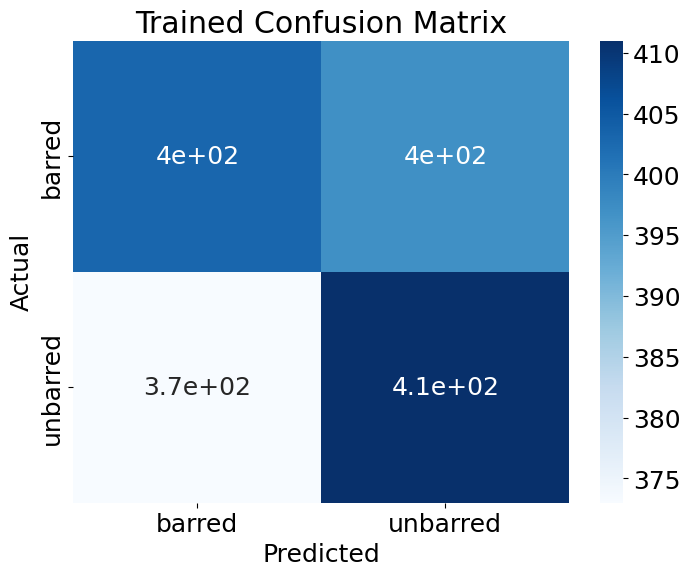

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Creating a confusion matrix to look at the classification model performance
y_pred_test = loaded_model.predict(ds_train)
y_pred = np.argmax(y_pred_test, axis=1)  

lab_true = []
for image, lab in ds_train:
    lab_true.append(lab.numpy())

lab_true = np.concatenate(lab_true, axis=0)

if len(lab_true.shape)>1:
    lab_true = np.argmax(lab_true, axis=1)
    
#PLotting the confusion matrix
cm = confusion_matrix(lab_true,  y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['barred', 'unbarred'], yticklabels=['barred', 'unbarred'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Trained Confusion Matrix')
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


2024-06-18 19:14:11.904548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


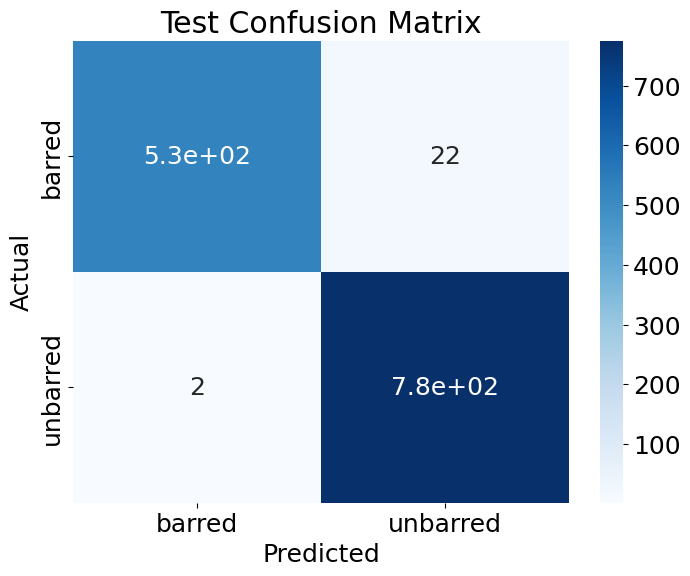

In [ ]:
#Confusion matrix
y_pred_test = loaded_model.predict(ds_test)
y_pred = np.argmax(y_pred_test, axis=1)  

#Getting test labels
lab_true = []
for image, lab in ds_test:
    lab_true.append(lab.numpy())

lab_true = np.concatenate(lab_true, axis=0)

if len(lab_true.shape)>1:
    lab_true = np.argmax(lab_true, axis=1)
    
    
#PLotting the confusion matrix
cm = confusion_matrix(lab_true,  y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['barred', 'unbarred'], yticklabels=['barred', 'unbarred'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()

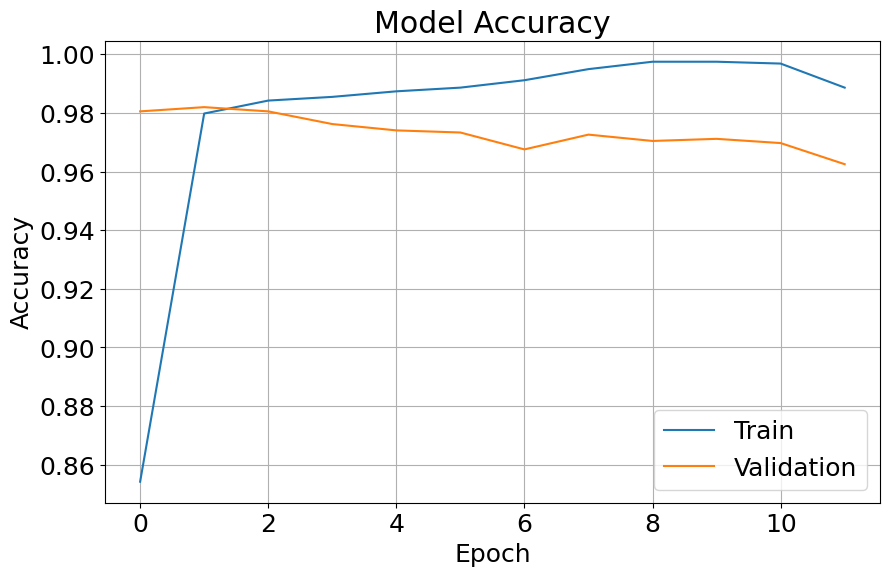

In [ ]:
#Plotting the model's accuracy
plt.figure(figsize=(10, 6))
plt.plot(loaded_history['accuracy'], label='Train')
plt.plot(loaded_history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

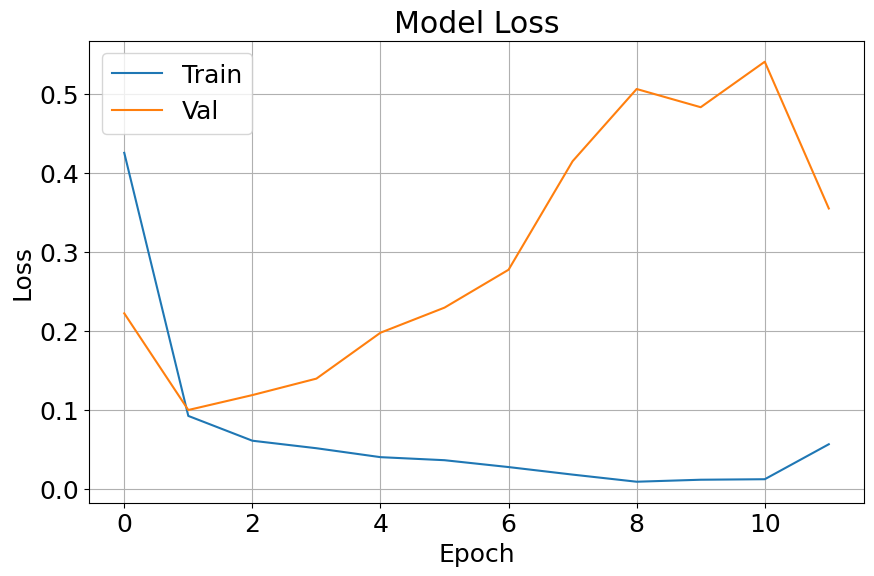

In [ ]:
#Plotting the model's losses
plt.figure(figsize=(10, 6))
plt.plot(loaded_history['loss'], label='Train')
plt.plot(loaded_history['val_loss'], label='Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

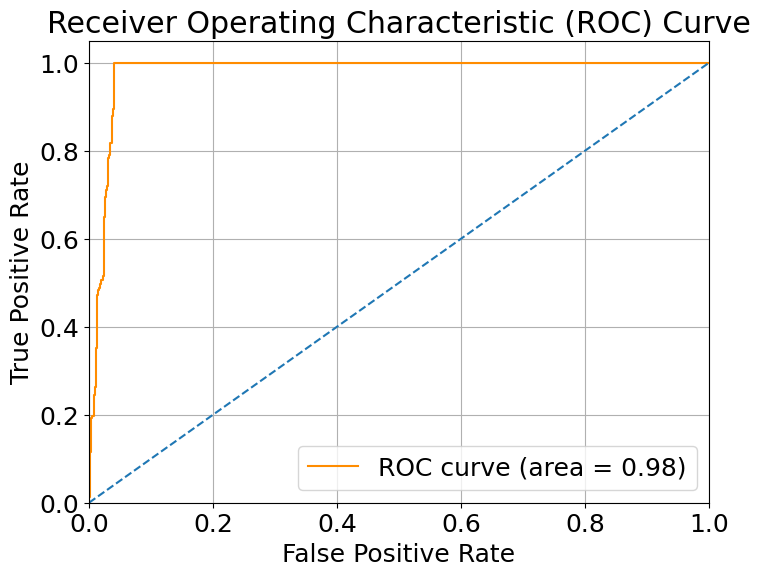

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(lab_true, y_pred_test[:, 1])  
roc_auc = auc(fpr, tpr)

#Plotting the Receiver Operating Characteristic (ROC) curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Making predictions on rest of the HSC

Now I will make predictions on an unlabelled dataset of galaxies using the model created. 

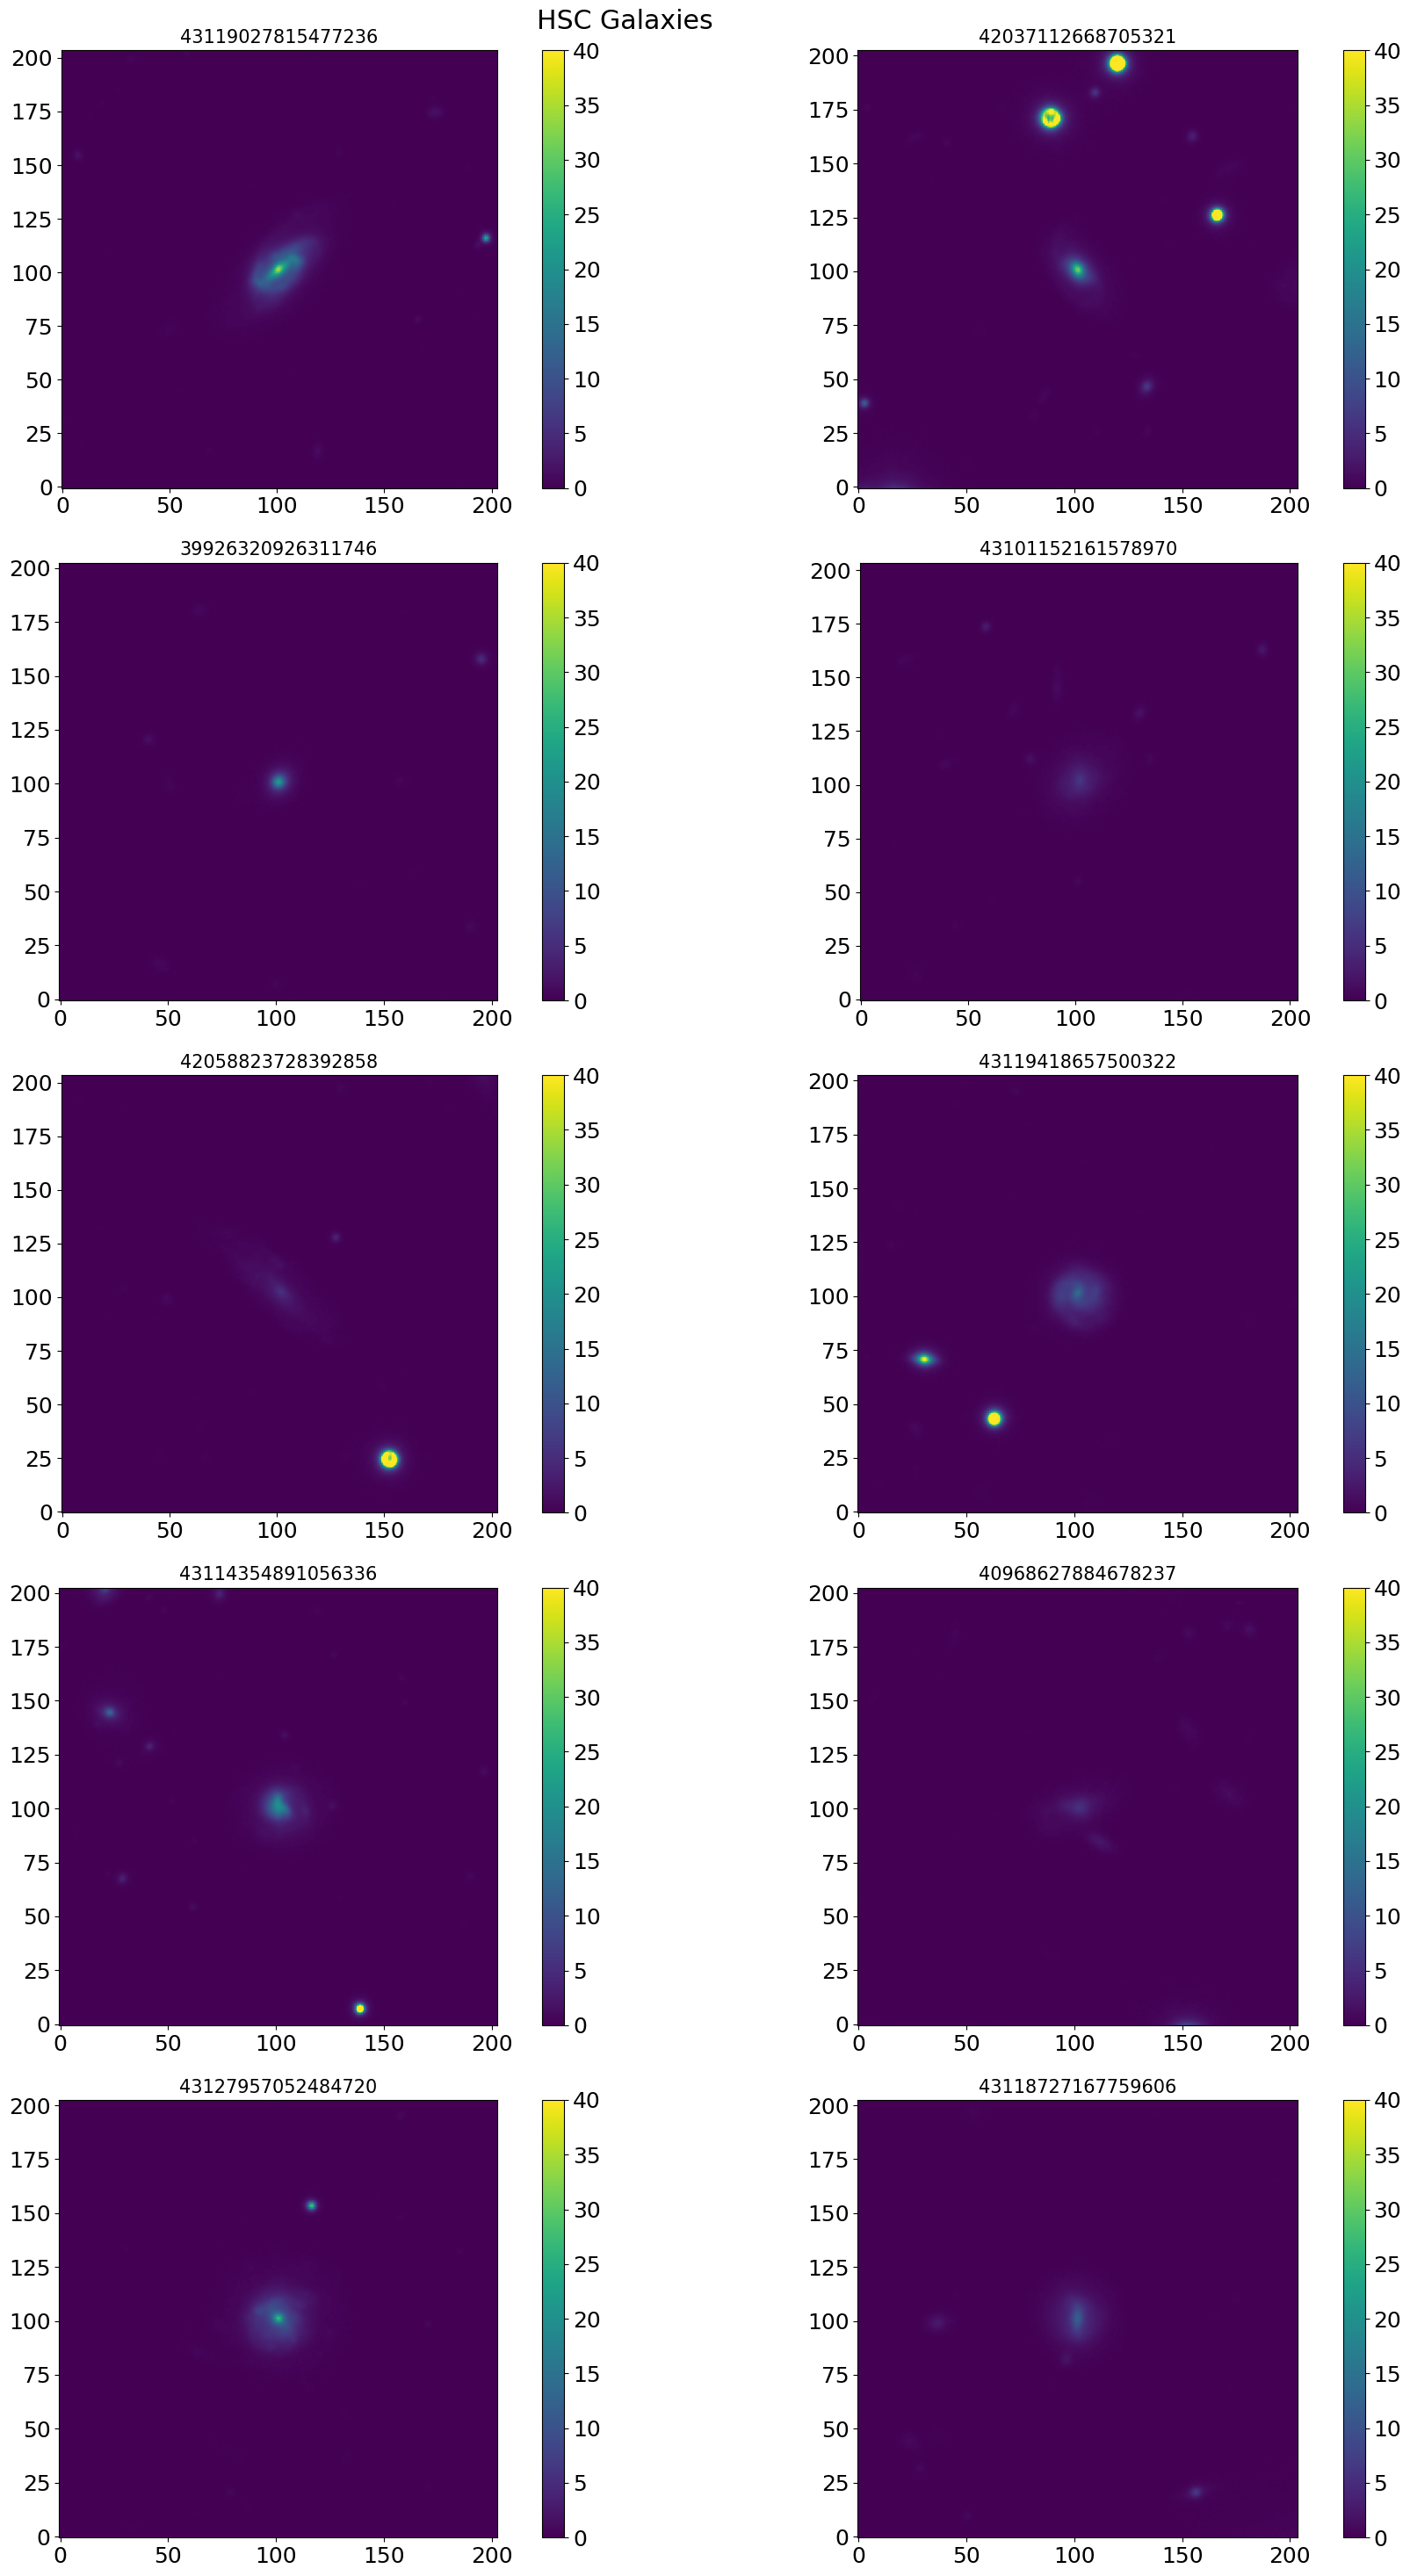

In [ ]:
#Loading and viewing the unlabelled imaging data 
fits_file = 'gama09_selected.fits'

hsc_files = [f for f in os.listdir(pred_dir) if f.endswith('.fits')]

fig, ax = plt.subplots(5,2, figsize=(20,30))
ax = ax.flatten()
count=0
for hsc in hsc_files:
    with fits.open(pred_dir+hsc) as hdul:
        header = hdul[0].header
        data = hdul[1].data

        cm = ax[count].imshow(data, cmap='viridis', origin='lower', vmin=0, vmax=40)
        ax[count].set_title(f'{hsc[:-5]}', fontsize=15)
        fig.colorbar(cm, ax=ax[count])

        count += 1
        if count >= 10:
            break
        hdul.close()

fig.suptitle("HSC Galaxies")
plt.tight_layout()
plt.show()

In [ ]:
#Creating the dataset for tensorflow
tfds_name = 'hsc_dataset:1.0.0' ##USER INPUT NEEDED##
datasets_path = '/Users/users/barrow/tensorflow_datasets/'##USER INPUT NEEDED##
batch_size = 64 ##USER INPUT NEEDED##

In [ ]:
#Loading the data as training set
hsc_train, hsc_info = tfds.load(
    tfds_name,
    data_dir=datasets_path,
    split="train",
    shuffle_files=False,
    as_supervised=False,
    with_info=True,
)

dataset_size = hsc_info.splits["all"].num_examples
print("Num_examples dataset:", dataset_size)



Num_examples dataset: 1217


In [ ]:
#Getting the image and data 
def split(data):
    return data['image'], data['name']

hsc = hsc_train.map(split)
hsc = hsc.cache()
hsc = hsc.batch(batch_size)
hsc = hsc.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
hsc = hsc.prefetch(buffer_size=16)

In [ ]:
#Optimization for training the deep learning model (Adam)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                   beta_1 = 0.9,
                                   beta_2=0.999,
                                   epsilon=1e-07,
                                   amsgrad=False,
                                   name='Adam')

metrics = ['accuracy']
loss = 'sparse_categorical_crossentropy'#'binary_crossentropy' 

In [ ]:
import codecs

#Loading history
path = f_history_1
if os.path.exists(path): 
    with codecs.open(path, "r", encoding="utf-8") as f:
        loaded_history = json.loads(f.read())


#Loading the model
json_file = open(f_model_1, "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)


#Loading the best weights into the new model
loaded_model.load_weights(f_best_weights_1)
print("Loaded model from disk")

#Evaluating the loaded model on the test data
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=metrics)

score = loaded_model.predict(hsc, verbose=True)

#Predictions
predicted_classes = np.argmax(score, axis=-1)
print(f"Predicted classes for the first 5 samples: {predicted_classes[:10]}")

Loaded model from disk
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
Predicted classes for the first 5 samples: [1 1 1 1 1 1 1 1 1 1]


In [ ]:
#Getting physical parameters
hsc_table = Table.read(fits_file, format='fits')
hsc_table

hsc_id,ra,dec,redshift,stellar_mass,stellar_mass_err,sfr,sfr_err,agn_luminosity,agn_luminosity_err,agn_fraction,agn_fraction_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
42054696264825563,137.76657655596364,1.1600807529156834,0.14,9673757296.066385,849724156.6460551,1.247428830980425,0.09779683723064343,5.006692024499317e+33,4.879697457389137e+34,0.0012329707124146049,0.011683449390946265
42042038996198519,132.6110714451533,0.6129910912546498,0.13,1513281781.8094018,237867896.98779863,0.41557004547353515,0.04635956569684351,2.210967896051701e+34,9.460241609304768e+34,0.013209732039876741,0.04910292949820136
43132350804031133,141.19071325681784,2.4997371763269283,0.11,4321043835.0722685,876886400.1314887,0.8338590721010529,0.051047629353405774,1.2595692015467555e+34,4.063589607726391e+34,0.03366745405662878,0.08991442680640249
43096608086183576,129.9284288699433,1.9809541286435537,0.1499,8118171134.184926,1342048436.7128825,1.777244582344087,0.11231585886003244,1.2922039783840083e+33,2.7524675006539936e+34,0.00024357507745726488,0.005106858305179828
43109823700552632,134.5191395292302,2.911450264745649,0.14,1901175913.9581316,273080922.96413714,0.5698817327993062,0.061245147378384,2.310297045136092e+34,9.3299391646815e+34,0.013494381674162415,0.04887975776029233
43114758617988464,135.15962539513953,2.49847593987462,0.12000000000000001,2513619664.381729,373469367.11568934,0.6665384328032634,0.05715663839762299,4.8637577056697345e+33,3.2445349424074945e+34,0.003574233935500758,0.023643787464284773
43123430156946960,138.26173481629718,2.901548747154103,0.13,8852746877.458296,1804027913.6367817,1.6077851633281266,0.1535223504945286,7.139957702892065e+33,6.60294783422238e+34,0.0014184723067707627,0.012719541808231089
39908037250536610,134.41517018394023,-1.814953443075276,0.12000000000000001,1031334354.4859761,124748579.37125783,0.33153279489071497,0.03140717668350894,5.790118034641315e+34,1.459297639675303e+35,0.08124651920553241,0.15141281127677722
39908178984457449,134.34753963528917,-1.617324553931229,0.10000000149011612,1409606827.1485677,228380656.3435796,0.43964494824031747,0.10345995311426762,3.656337798317105e+35,1.4701846652065883e+35,0.2125864108568563,0.06386164889278831


In [ ]:
#Creating a dataframe with everything in it
data = {
    'prediction': predicted_classes,
    'redshift': hsc_table['redshift'].astype(np.float64),
    'stellar_mass': hsc_table['stellar_mass'].astype(np.float64),
    'sfr': hsc_table['sfr'].astype(np.float64),
    'agn_luminosity': hsc_table['agn_luminosity'].astype(np.float64),
    'agn_fraction': hsc_table['agn_fraction'].astype(np.float64)
}
df = pd.DataFrame(data)
df

,prediction,redshift,stellar_mass,sfr,agn_luminosity,agn_fraction
0,1,0.1400,9.673757e+09,1.247429,5.006692e+33,0.001233
1,1,0.1300,1.513282e+09,0.415570,2.210968e+34,0.013210
2,1,0.1100,4.321044e+09,0.833859,1.259569e+34,0.033667
3,1,0.1499,8.118171e+09,1.777245,1.292204e+33,0.000244
4,1,0.1400,1.901176e+09,0.569882,2.310297e+34,0.013494
...,...,...,...,...,...,...
1212,1,0.1200,3.801013e+09,0.526779,1.476890e+34,0.053836
1213,1,0.1000,1.553976e+09,0.399059,1.636327e+34,0.054540
1214,1,0.1100,2.376343e+09,0.661861,5.098012e+34,0.085015
1215,1,0.1115,1.148628e+10,1.482975,1.957387e+35,0.041029


In [ ]:
#Looking at barred and unbarred data
barred_galaxies = df[df['prediction'] == 0]
unbarred_galaxies = df[df['prediction'] == 1]

barred_stats = barred_galaxies.describe()
unbarred_stats = unbarred_galaxies.describe()

print("Barred Galaxies Statistics:", barred_stats)
print("Unbarred Galaxies Statistics:", unbarred_stats)

Barred Galaxies Statistics:        prediction   redshift  stellar_mass        sfr  agn_luminosity  \
count        10.0  10.000000  1.000000e+01  10.000000    1.000000e+01   
mean          0.0   0.125477  1.160004e+10   1.864243    3.001373e+35   
std           0.0   0.016884  1.176634e+10   1.360601    8.179632e+35   
min           0.0   0.100000  1.848762e+09   0.560836    6.610953e+32   
25%           0.0   0.112500  4.217777e+09   0.824658    2.541151e+33   
50%           0.0   0.127005  5.420502e+09   1.222892    9.437674e+33   
75%           0.0   0.138547  1.856298e+10   2.703415    4.209825e+34   
max           0.0   0.149720  3.552832e+10   4.589436    2.614256e+36   

       agn_fraction  
count     10.000000  
mean       0.068095  
std        0.142554  
min        0.000063  
25%        0.000482  
50%        0.006461  
75%        0.068219  
max        0.458138  
Unbarred Galaxies Statistics:        prediction     redshift  stellar_mass          sfr  agn_luminosity  \
count    

In [ ]:
barred_galaxies

,prediction,redshift,stellar_mass,sfr,agn_luminosity,agn_fraction
148,0,0.13900,5.921067e+09,0.811303,2.915358e+35,0.107940
449,0,0.10485,3.552832e+10,4.589436,6.610953e+32,0.000063
450,0,0.13401,2.172921e+10,2.806894,1.540612e+33,0.000302
603,0,0.14972,9.064291e+09,2.392978,1.337097e+34,0.007015
625,0,0.13719,2.586654e+10,3.375372,2.390678e+33,0.000191
852,0,0.12000,2.548523e+09,0.795100,2.614256e+36,0.458138
869,0,0.10000,4.148702e+09,0.864724,5.504381e+33,0.005908
1037,0,0.11000,1.848762e+09,0.560836,1.948518e+34,0.086249
1109,0,0.12000,4.919937e+09,1.150610,2.992570e+33,0.001019
1121,0,0.14000,4.425002e+09,1.295174,4.963594e+34,0.014129


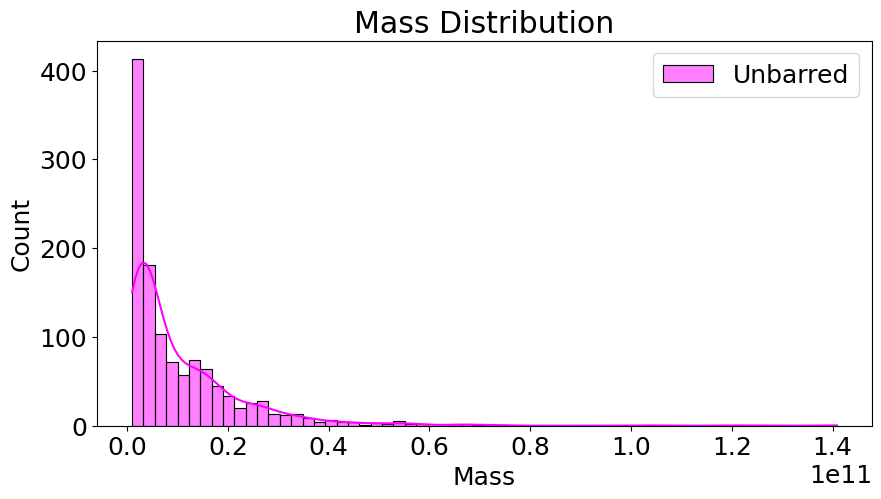

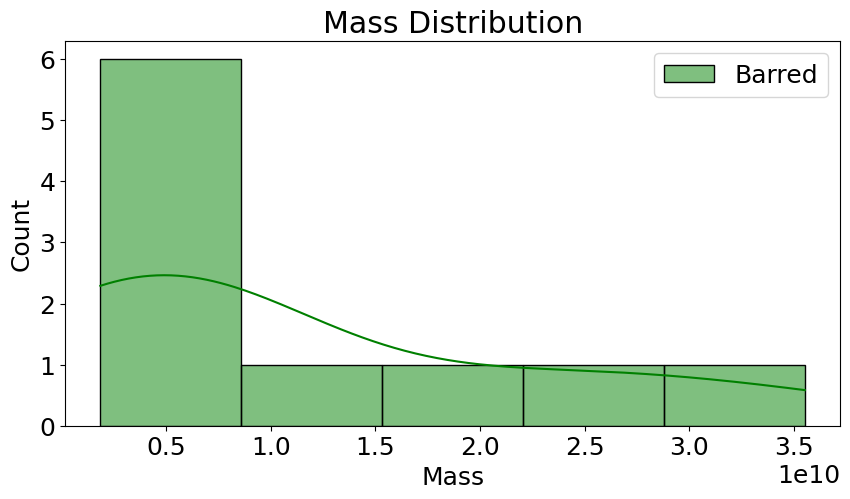

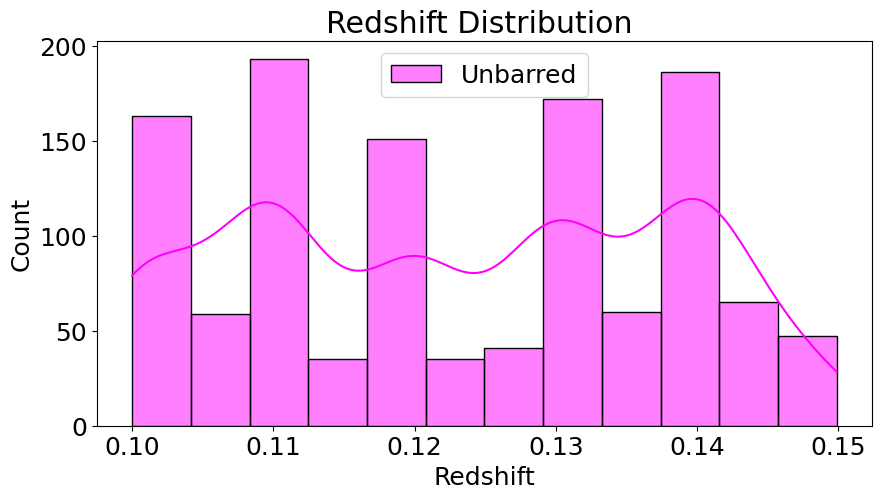

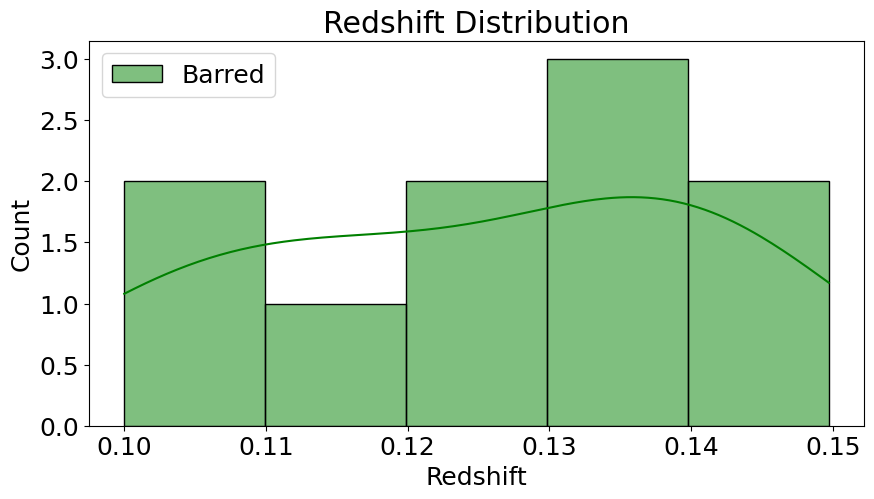

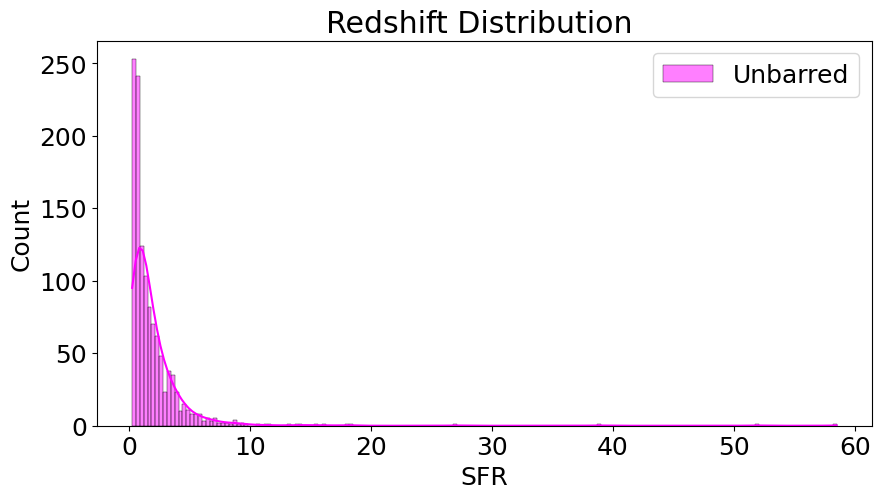

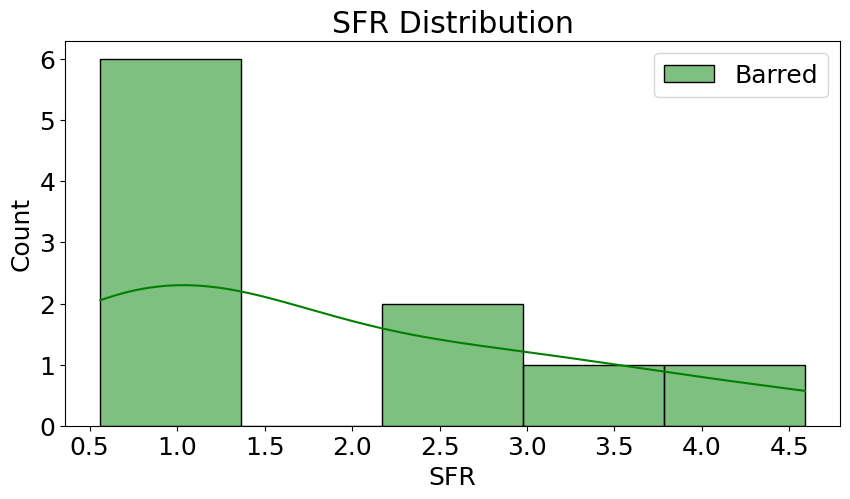

In [ ]:
#Analysing the bar/non-bar galaxies as a function of different physical properties 
plt.figure(figsize=(10, 5))
sns.histplot(unbarred_galaxies['stellar_mass'], kde=True, color='magenta', label='Unbarred')
plt.xlabel('Mass')
plt.ylabel('Count')
plt.title('Mass Distribution')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(barred_galaxies['stellar_mass'], kde=True, color='green', label='Barred')
plt.xlabel('Mass')
plt.ylabel('Count')
plt.title('Mass Distribution')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(unbarred_galaxies['redshift'], kde=True, color='magenta', label='Unbarred')
plt.xlabel('Redshift')
plt.ylabel('Count')
plt.title('Redshift Distribution ')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(barred_galaxies['redshift'], kde=True, color='green', label='Barred')
plt.xlabel('Redshift')
plt.ylabel('Count')
plt.title('Redshift Distribution')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(unbarred_galaxies['sfr'], kde=True, color='magenta', label='Unbarred')
plt.xlabel('SFR')
plt.ylabel('Count')
plt.title('Redshift Distribution ')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(barred_galaxies['sfr'], kde=True, color='green', label='Barred')
plt.xlabel('SFR')
plt.ylabel('Count')
plt.title('SFR Distribution')
plt.legend()
plt.show()


